# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
                 "dog cat animal", "cat animal dog", "cat dog animal"]

In [3]:
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [4]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['apple', 'cat', 'fruit', 'banana', 'animal', 'dog']

In [5]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'apple': 0, 'cat': 1, 'fruit': 2, 'banana': 3, 'animal': 4, 'dog': 5}


In [6]:
#vocab size
voc_size = len(vocab)
print(voc_size)

6


In [7]:
#append UNK
vocab.append('<UNK>')

In [8]:
vocab

['apple', 'cat', 'fruit', 'banana', 'animal', 'dog', '<UNK>']

In [9]:
word2index['<UNK>'] = 0

In [10]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [11]:
from collections import Counter

X_i = Counter(flatten(corpus))
X_i

Counter({'apple': 3, 'banana': 3, 'fruit': 3, 'dog': 3, 'cat': 3, 'animal': 3})

In [12]:
skip_grams = []

for doc in corpus:
    for i in range(1, len(doc)-1):
        center = doc[i]
        outside = [doc[i-1], doc[i+1]]
        for each_out in outside:
            skip_grams.append((center, each_out))
skip_grams

[('banana', 'apple'),
 ('banana', 'fruit'),
 ('apple', 'banana'),
 ('apple', 'fruit'),
 ('fruit', 'banana'),
 ('fruit', 'apple'),
 ('cat', 'dog'),
 ('cat', 'animal'),
 ('animal', 'cat'),
 ('animal', 'dog'),
 ('dog', 'cat'),
 ('dog', 'animal')]

In [13]:
X_ik_skipgrams = Counter(skip_grams)
X_ik_skipgrams

Counter({('banana', 'apple'): 1,
         ('banana', 'fruit'): 1,
         ('apple', 'banana'): 1,
         ('apple', 'fruit'): 1,
         ('fruit', 'banana'): 1,
         ('fruit', 'apple'): 1,
         ('cat', 'dog'): 1,
         ('cat', 'animal'): 1,
         ('animal', 'cat'): 1,
         ('animal', 'dog'): 1,
         ('dog', 'cat'): 1,
         ('dog', 'animal'): 1})

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

<img src = "../figures/glove_weighting_func.png" width=400>

In [14]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [15]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

## 3. Prepare train data

In [16]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [17]:
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [18]:
x

array([[1],
       [2]])

In [19]:
y

array([[5],
       [0]])

In [20]:
cooc

array([[0.69314718],
       [0.69314718]])

In [21]:
weighting

array([[0.05318296],
       [0.05318296]])

## 4. Model

<img src ="../figures/glove.png" width=400>

In [22]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [23]:
#test our system
voc_size = len(vocab)
emb_size = 2
model = Glove(voc_size, emb_size)

In [24]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [25]:
loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

In [26]:
loss

tensor(0.0150, grad_fn=<SumBackward0>)

## 5. Training

In [28]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 0.129271 | time: 0m 0s
Epoch: 2000 | cost: 0.000088 | time: 0m 0s
Epoch: 3000 | cost: 0.000000 | time: 0m 0s
Epoch: 4000 | cost: 0.000000 | time: 0m 0s
Epoch: 5000 | cost: 0.000000 | time: 0m 0s


## 6. Plotting the embeddings

In [31]:
#list of vocabs
vocab[:10]

['apple', 'cat', 'fruit', 'banana', 'animal', 'dog', '<UNK>']

In [32]:
word = vocab[0]

In [33]:
#numericalization
id = word2index[word]
id

0

In [34]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [36]:
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[ 0.5743, -0.6562]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.1942, 0.8031]], grad_fn=<EmbeddingBackward0>))

In [38]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed

tensor([[0.3843, 0.0734]], grad_fn=<DivBackward0>)

In [41]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

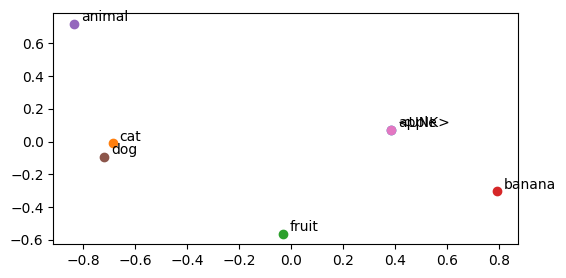

In [42]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [43]:
vocab

['apple', 'cat', 'fruit', 'banana', 'animal', 'dog', '<UNK>']

In [44]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [45]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.07236174001427882
cat vs. animal:  0.747020177091881
cat vs. cat:  1.0000000000000002


In [46]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.07236174001427886
cat vs. animal:  0.747020177091881
cat vs. cat:  1
